Importo librerias necesarias

In [1]:
import json
import pandas as pd
import tensorflow as tf

Leo el archivo que con el set de datos limpios

In [2]:
df = pd.read_json("2_cars_to_model_process.json", orient="columns")
df.tail()
#elimino columna sin valores o con problemas
df.pop('TIER 2 B7')

0       0
1       0
10      0
100     0
1000    0
1001    0
1002    0
1003    0
1004    0
1005    0
1006    0
1007    0
1008    0
1009    0
101     0
1010    0
1011    0
1012    0
1013    0
1014    0
1015    0
1016    0
1017    0
1018    0
1019    0
102     0
1020    0
1021    0
1022    0
1023    0
       ..
972     0
973     0
974     0
975     0
976     0
977     0
978     0
979     0
98      0
980     0
981     0
982     0
983     0
984     0
985     0
986     0
987     0
988     0
989     0
99      0
990     0
991     0
992     0
993     0
994     0
995     0
996     0
997     0
998     0
999     0
Name: TIER 2 B7, Length: 2850, dtype: int64

Reservamos un 80% de los datos para entrenamiento

In [3]:
train_dataset = df.sample(frac=0.8,random_state=0) 

El resto de los datos son para test o sea un 20%

In [4]:
test_dataset = df.drop(train_dataset.index)

Elimino del set de datos la columna que queremos predecir y lo dejamos almacenadas en 2 variables de train y test
,para su posterior uso en las evaluciones 

In [5]:
train_labels = train_dataset.pop('rendimientoMixto')
test_labels = test_dataset.pop('rendimientoMixto')

#Normalizamos los datos de entrada.
Vemos como estan las medianas y desviaciones de los datos, lo guardo para normalizar el modelo en PROD

In [6]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats.to_json('3_train_stats.json')
train_stats 

,count,mean,std,min,25%,50%,75%,max
cilindrada,2280.0,2.294298,1.127685,0.8,1.5,2.0,3.0,6.6
EURO V,2280.0,0.689474,0.462811,0.0,0.0,1.0,1.0,1.0
EURO VI,2280.0,0.245614,0.430545,0.0,0.0,0.0,0.0,1.0
TIER 3 B50,2280.0,0.000877,0.029611,0.0,0.0,0.0,0.0,1.0
TIER 2 B5,2280.0,0.026754,0.161400,0.0,0.0,0.0,0.0,1.0
TIER 2 B4,2280.0,0.014474,0.119459,0.0,0.0,0.0,0.0,1.0
TIER 3 B70,2280.0,0.016667,0.128047,0.0,0.0,0.0,0.0,1.0
TIER 2 B6,2280.0,0.000439,0.020943,0.0,0.0,0.0,0.0,1.0
TIER 2 B8,2280.0,0.000439,0.020943,0.0,0.0,0.0,0.0,1.0
Tier 3 B125,2280.0,0.000439,0.020943,0.0,0.0,0.0,0.0,1.0


Normalizamos , creamos la funcion norm, esta funcion reescala a un rango [0,1](normaliza),
y centra las columnas  con respecto a una media 0 con desviacion estandar 1(estandarizacion),
de forma que las columnas de características tengan los mismos parámetros que una distribución normal

In [7]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

Normalizamos el set de entrenamiento

In [8]:
normed_train_data = norm(train_dataset) 

Normalizamos el set de de test para inferir luego

In [9]:
normed_test_data = norm(test_dataset) 
normed_test_data.to_json('4_normed_test_data.json') 

Verificacion de normalizacion y estandarizacion


In [10]:
normed_train_stats = normed_train_data.describe().transpose()

#DEFINIMOS EL MODELO------
Esperamos solo un valor continuo, sin funcion de activacion o sea una capa final dense(1).
Definimos 2 capas inciales densamente conectadas de 64 neuronas. Con la primera capa de tamano de entrada igual al set de entrenamiento.

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

def build_model():
  model = Sequential()
  model.add(Dense(64, activation='relu',input_shape=[len(train_dataset.keys())]))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  return model

Creamos el modelo

In [12]:
model=build_model()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2048      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,273
Trainable params: 6,273
Non-trainable params: 0
_________________________________________________________________


#Configuracion del modelo
Se empleara como optimizador RMSprop, como funcion de perdida MSE, con metricas MSE y MAE

In [14]:
optimizer = tf.keras.optimizers.RMSprop(0.001)
#ratio de aprendizaje de 0.001

In [15]:
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

Al modelo le agregaremos una funcion de callback EarlyStopping, esta,  interrumpe el entrenamiento cuando las metricas de la funcion de perdida, para los datos de validacion, no mejoran luego de 20 epocks.


In [16]:
early_stop= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

Se correran 1000 epocks . Se sacaran un 20% para datos de validacion de los datos de entrenamiento. Se desactiva el verbose a 0 para no acumular en pantalla tantos datos

In [17]:
EPOCHS = 1000

history = model.fit(
            normed_train_data, train_labels,
            epochs=EPOCHS, validation_split = 0.2, verbose=0,callbacks=[early_stop]) 

Vemos del historial las estadisticas almacenadas

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail() 

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
102,2.158622,1.132213,2.158622,2.253383,1.144934,2.253383,102
103,2.167489,1.139756,2.167489,2.408399,1.156266,2.408399,103
104,2.174398,1.130997,2.174398,2.345489,1.159116,2.345490,104
105,2.171928,1.139337,2.171928,2.236602,1.134623,2.236602,105
106,2.159909,1.133869,2.159909,2.205422,1.124852,2.205422,106


Graficamos la evolucion de los  datos de error tanto de los valores de entrenamiento como los de validacion

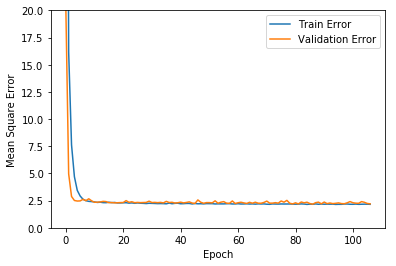

In [26]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
            label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Validation Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)
 

Evaluamos el error absoluto medio, que es mas humanamente comprensible, este nos retorna un error muy bajo.
El cual indica que el modelo es bueno.

In [20]:
loss, mse, mae = model.evaluate(normed_test_data, test_labels)
print("Testing set Mean Abs Error: {:.2f} KM".format(mae))
print("Testing set Mean Sqr Error: {:.2f} KM".format(mse))
 

570/570 [==============================] - 0s 38us/sample - loss: 2.2118 - mae: 1.1707 - mse: 2.2118
Testing set Mean Abs Error: 2.21 KM
Testing set Mean Sqr Error: 1.17 KM


Guardamos el modelo obtenido en un archivo H5

In [21]:
# Guardar el Modelo
model.save('cars_model.h5')

Levantamos el archivo de entrenamiento, este sera el transportable al destino final en produccion

In [22]:

# Recrea exactamente el mismo modelo solo desde el archivo
loaded_model = tf.keras.models.load_model('cars_model.h5')


Predecimos el primer valor del set de datos de test normalizado , y comparamos con el valor real almacenado en test_labels, antes visualizamos el modelo de auto que vamos a inferir.

In [25]:
test_dataset.head(1)

,cilindrada,EURO V,EURO VI,TIER 3 B50,TIER 2 B5,TIER 2 B4,TIER 3 B70,TIER 2 B6,TIER 2 B8,Tier 3 B125,...,Roadster,Camioneta,Minivan,Furgón Cerrado,Minibus,Microvan,4x2,4x4,M,A
0,1.4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


Inferimos el valor final

In [24]:
Xnew = loaded_model.predict(normed_test_data)
print("Predicted=%s , Real=%s" % (Xnew[0],test_labels[0]))

Predicted=[16.1754] , Real=16.7
